In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto, FakeJakartaV2, FakeProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)
fig_path = f'{module_path}/figs'


from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC,QRewindingRC_Async,QRewindingRC_Custom,  QRewindingRC_Neat
from src.data import DataSource

from iqm.qiskit_iqm import IQMFakeAdonis
from iqm.qiskit_iqm import IQMProvider,transpile_to_IQM

server_url = "https://cocos.resonance.meetiqm.com/garnet"  # For example https://cocos.resonance.meetiqm.com/garnet
api_token = "287K1FQqLZ9JU+FxO6C4l6TXENKy0SFUO8h5P4po3DIGZeGb5qhzo4AAi21PIAqd"

SHOTS = 8000

backend = IQMProvider(server_url, token=api_token).get_backend()

In [ ]:
Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                              'add_y_to_input':True, # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.

                              #Not used for real backend:
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':4, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn_poly', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              'file_name':'New_Class_Testing',
                              'max_batch': 31250, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'max_circuit' : 1000,
                              'verbose': True,
                              'calibration_set_id' : None,
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19,
                              'max_concurrent': 100,
                              'simulate': True,
                              'manual': True

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters


new_class = QRewindingRC_Neat(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
new_class.prepare(data)

In [ ]:
new_class.train(resume=False)

In [ ]:
new_class.plot_train(px=True, nepisodes=1)

In [ ]:
new_class.mse_train

In [ ]:
Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                              'add_y_to_input':True, # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.

                              #Not used for real backend:
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':4, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':1, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              'file_name':'New_Class_Testing',
                              'max_batch': 31250, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'max_circuit' : 1000,
                              'verbose': True,
                              'calibration_set_id' : None,
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19,
                              'max_concurrent': 100,
                              'simulate': True,
                              'manual': True

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters


In [ ]:
new_class_lin = QRewindingRC_Neat(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
new_class_lin.prepare(data)

In [ ]:
new_class_lin.weights.__dict__

In [ ]:
new_class_lin.train(resume=False)

In [ ]:
new_class_lin.plot_train(px=True, nepisodes=1)

In [ ]:
new_class_lin.mse_train

In [ ]:
new_class.__dict__.keys()

In [ ]:
np.round(new_class.weights.coef_,4).shape

In [ ]:
plt.scatter(range(103),np.round(new_class.weights.coef_,4))

In [ ]:
plt.scatter([1,2,3],[1,2,3])

In [2]:
Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                              'add_y_to_input':True, # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.

                              #Not used for real backend:
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':4, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':False, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn_poly', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              'file_name':'New_Class_Testing_no_x',
                              'max_batch': 31250, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'max_circuit' : 1000,
                              'verbose': True,
                              'calibration_set_id' : None,
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19,
                              'max_concurrent': 100,
                              'simulate': True,
                              'manual': True

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters


new_class_no_x = QRewindingRC_Neat(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
new_class_no_x.prepare(data)

IQM
You have specified  19 qubits required. Correct?
Using Hard-coded layout


In [ ]:
new_class_no_x.train(resume=False)


In [ ]:
new_class_no_x.interpret_training_results()
print(np.sqrt(new_class_no_x.mse_train))
new_class_no_x.plot_train(px=True, nepisodes=1)

In [ ]:
new_class_no_x.reinterpret_with_inputs()
print(np.sqrt(new_class_no_x.mse_train))
new_class_no_x.plot_train(px=True, nepisodes=1)

In [ ]:
new_class_no_x.reinterpret_only_inputs()
print(np.sqrt(new_class_no_x.mse_train))
new_class_no_x.plot_train(px=True, nepisodes=1)

In [3]:
new_class_no_x.train(resume=True)

resuming on interpretation


In [4]:
new_class_no_x.val(resume=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


MSE per episode
 [[  6.         293.35035859]
 [  0.         338.47646806]
 [ 10.         367.29738807]
 [  9.         386.46662524]
 [  1.         414.7482192 ]
 [  8.         418.96610466]
 [  7.         419.93995427]
 [ 13.         421.18316729]
 [  5.         460.61866284]
 [  4.         463.8489762 ]
 [  3.         551.15496906]
 [ 11.         557.80748067]
 [  2.         584.9727996 ]
 [ 12.         638.92609909]
 [ 14.         639.41539343]]


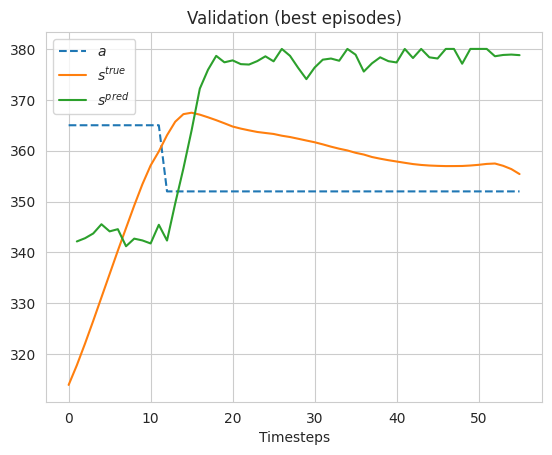

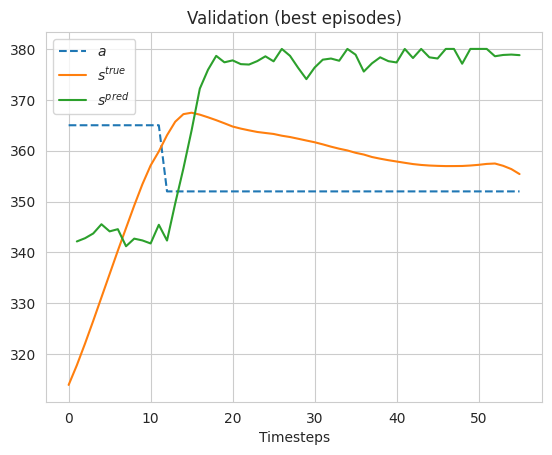

In [7]:
new_class_no_x.plot_best_val_episodes(None,1)

In [3]:
new_class_no_x.reinterpret_with_inputs()
new_class_no_x.val_with_inputs(resume=False)

Loaded counts from file


MSE per episode
 [[ 9.          2.68292981]
 [ 8.          3.83493731]
 [ 7.          3.85052276]
 [10.          4.1900668 ]
 [ 2.          5.29520494]
 [ 1.          5.42735575]
 [ 3.          6.06416525]
 [11.          6.37558433]
 [ 5.          7.05641887]
 [ 6.          7.10682611]
 [ 4.          7.28040835]
 [ 0.          8.7712343 ]
 [13.         16.00182936]
 [14.         16.81792122]
 [12.         21.68476113]]


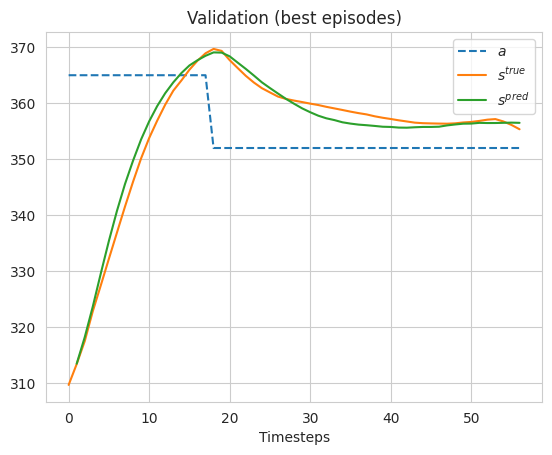

2.9516873108956934

In [4]:
new_class_no_x.plot_best_val_episodes(None,1)
np.sqrt(new_class_no_x.mse_val)

Loaded counts from file
MSE per episode
 [[ 8.          2.90188209]
 [ 9.          3.01524225]
 [ 2.          3.87599802]
 [11.          4.0087617 ]
 [ 3.          4.19590477]
 [ 7.          4.20782566]
 [ 1.          4.42857194]
 [10.          5.19357637]
 [ 6.          5.33146174]
 [ 0.          6.32139225]
 [ 5.          6.37910212]
 [ 4.          7.29529154]
 [13.         11.17695351]
 [14.         14.5373452 ]
 [12.         18.4052882 ]]


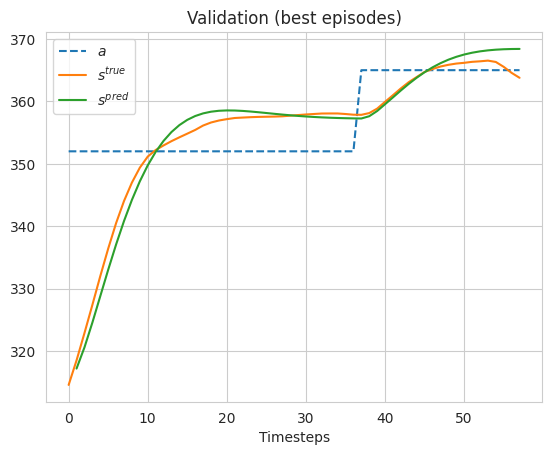

2.6894616989247573

In [5]:
new_class_no_x.reinterpret_only_inputs()
new_class_no_x.val_only_inputs(resume=False)
new_class_no_x.plot_best_val_episodes(None,1)
np.sqrt(new_class_no_x.mse_val)

In [21]:
np.array(new_class_no_x.data.yval[0][0])

array([0.11995117])

In [24]:
new_class_no_x.yval[0].shape

(56, 1)

In [25]:
np.concatenate([np.array([new_class_no_x.data.yval[0][0]]),new_class_no_x.yval[0]])

array([[0.11995117],
       [0.49356698],
       [0.49792897],
       [0.5030278 ],
       [0.48161087],
       [0.51022287],
       [0.49940727],
       [0.55666126],
       [0.62819152],
       [0.70916968],
       [0.80327339],
       [0.90490814],
       [0.91888421],
       [0.98889562],
       [0.9723969 ],
       [0.99165198],
       [0.97390881],
       [0.94999247],
       [0.98920815],
       [0.99429127],
       [1.        ],
       [0.97283612],
       [0.97649786],
       [0.97450138],
       [0.9459537 ],
       [1.        ],
       [0.97950443],
       [1.        ],
       [0.97631192],
       [0.92785254],
       [0.95290275],
       [0.97510954],
       [0.95862558],
       [0.96822426],
       [0.99201371],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.95412687],
       [0.98700961],
       [0.98833082],
       [0.98288297],
       [0.99572172],
       [0.999218  ],
       [1.        ],
       [0.97954584],
       [0.985

In [7]:
len(new_class_no_x.yval[0])

56

In [7]:
[len(new_class_no_x.data.xval[0]),len(new_class_no_x.data.yval[0])]

[57, 57]

In [18]:
import pickle as pkl
with open('New_Class_Testing_no_x_val/%s/saved_ypred.pkl' % (87),'rb') as ypred_file:
        test_all=pkl.load(ypred_file)

In [19]:
test_allc=test_all[0]
test_allc.insert(0,1)
print(len(test_allc))


57


In [14]:
teestc=[1,2,3,4]
teestc.insert(0,100)
teestc

[100, 1, 2, 3, 4]

In [8]:
[len(x) for x in new_class_no_x.data.xval]

[57, 57, 59, 57, 60, 62, 56, 59, 58, 57, 58, 58, 88, 56, 55]

In [9]:
new_class_no_x.xval[0].shape

(204, 1)

In [7]:
test=np.array([1,2,3,4,5,6])
test[test<4]

array([1, 2, 3])

In [ ]:
('test'+('_%s/saved_circuits' % (0)),'wb')

In [ ]:
new_class_no_x.reinterpret_with_inputs()

In [ ]:
new_class_no_x.plot_train(px=True, nepisodes=1)

In [ ]:
new_class_no_x.weights.coef_.shape

In [ ]:
plt.plot(range(110),new_class_no_x.weights.coef_.reshape(110,1))

In [17]:
for i in range(10):
    if i%2==0:
        continue
    print(i)

1
3
5
7
9
